<a href="https://colab.research.google.com/github/sid2901/ds_Assignment2/blob/main/DSAssignment2(AEDA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Netflix Data Analysis and Predictive Modeling


## Section 1: Data Loading and Preprocessing


The dataset is loaded using pd.read_csv() for further analysis.

Missing values in the date_added column are handled using pd.to_datetime() with errors='coerce', converting invalid dates to NaT.

Missing dates are imputed using the release_year, assuming content was added at the beginning of the release year.

Other categorical and numeric columns are handled using SimpleImputer with a mode imputation strategy.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [5]:
# Load the dataset
df = pd.read_csv('netflix_titles.csv')

## Section 2: Handling Missing Values

Mode imputation ensures missing values are filled using the most frequent value within the respective column.

This method is effective for categorical data like rating or type since these columns tend to have dominant categories.

In [6]:
# Impute missing 'date_added' using mode or based on 'release_year'
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['date_added'].fillna(pd.to_datetime(df['release_year'].astype(str) + '-01-01'), inplace=True)

# Fill other missing values using mode imputation
imputer = SimpleImputer(strategy='most_frequent')
df.iloc[:, :] = imputer.fit_transform(df)

<ipython-input-6-096f04b98348>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['date_added'].fillna(pd.to_datetime(df['release_year'].astype(str) + '-01-01'), inplace=True)


## Section 3: Exploratory Data Analysis (EDA)


A Correlation Heatmap is used to visualize the strength and direction of linear relationships between numerical features. Only numeric columns are used for accurate analysis.

A Box Plot visualizes the relationship between content rating and release_year, detecting outliers that may need further analysis.

A Pair Plot is used to observe interactions between numerical features like release_year, rating, year_added, and years_to_add, identifying any linear or non-linear patterns.

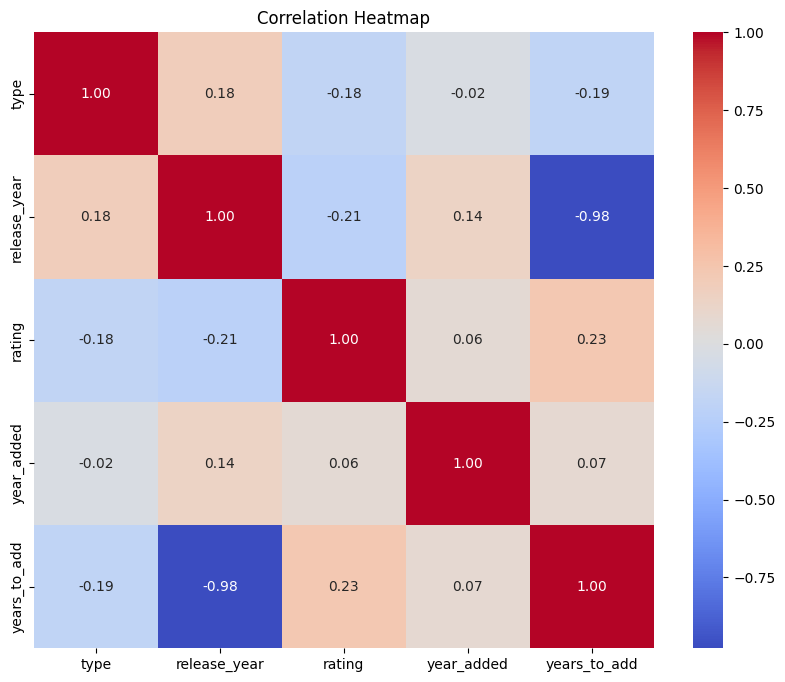

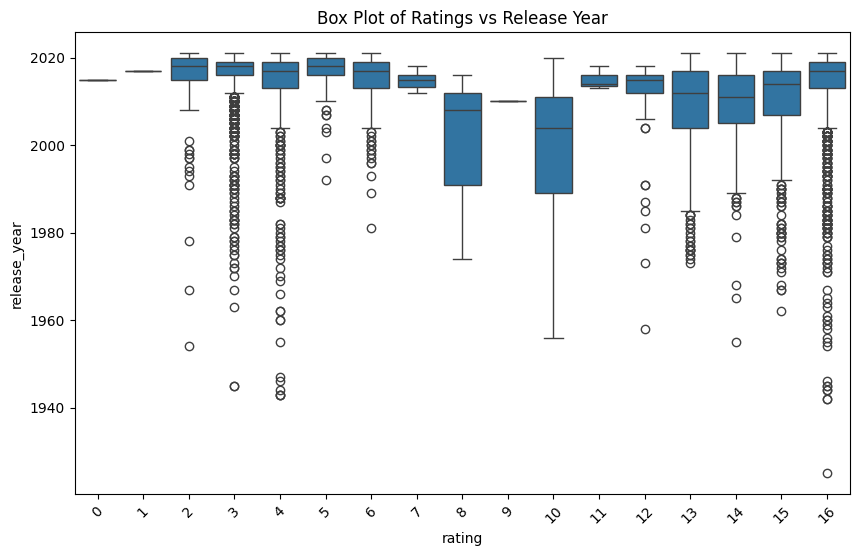

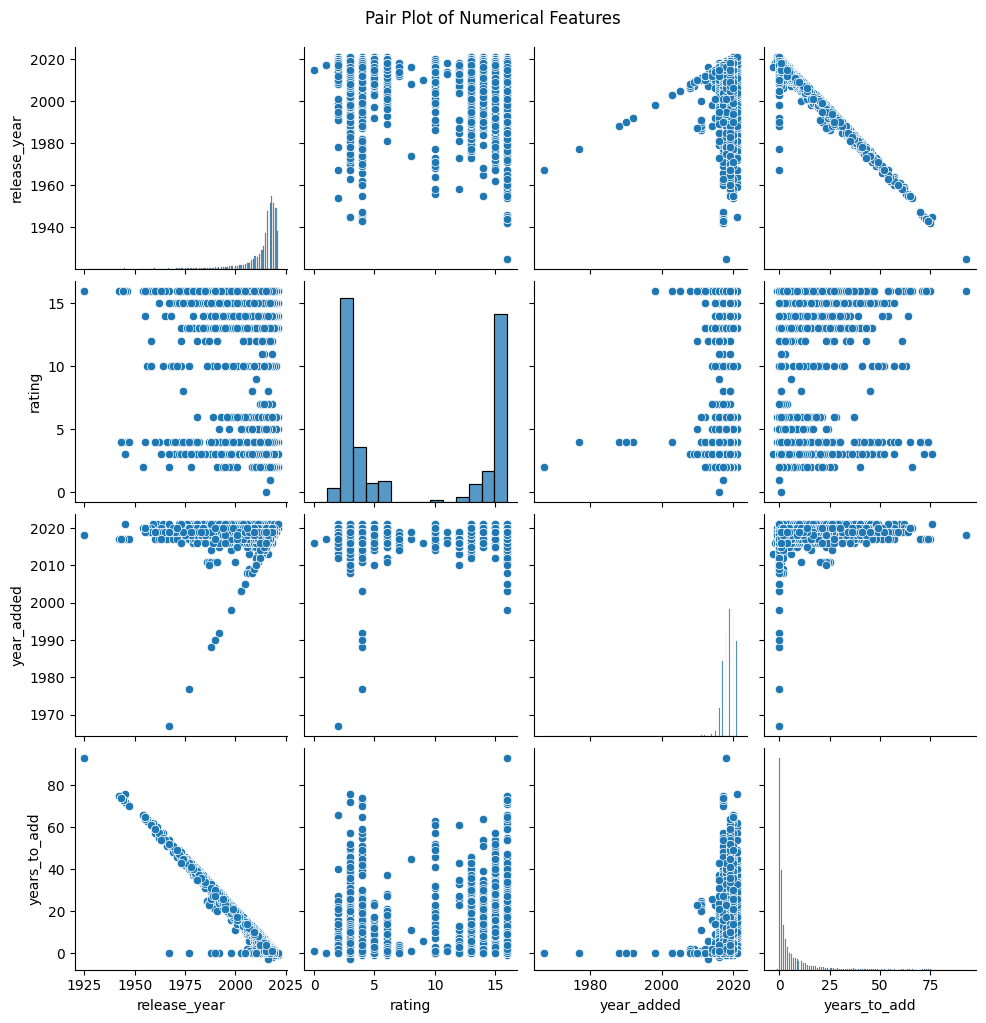

In [22]:
# Focus on movies for numerical analysis (assumes 'duration' for movies is in format "90 min")
movies = df[df['type'] == 'Movie'].copy()

# Extract numeric duration from the 'duration' column (e.g., "90 min")
movies['duration_num'] = movies['duration'].str.extract('(\d+)').astype(float)

# # Create a correlation matrix for 'release_year' and 'duration_num'
corr_matrix = movies[['release_year', 'duration_num']].corr()

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Box plot for outlier detection
plt.figure(figsize=(10,6))
sns.boxplot(x='rating', y='release_year', data=df)
plt.title('Box Plot of Ratings vs Release Year')
plt.xticks(rotation=45)
plt.show()
# Pair plot for feature relationships
sns.pairplot(df[['release_year', 'rating', 'year_added', 'years_to_add']])
plt.suptitle('Pair Plot of Numerical Features', y=1.02)
plt.show()

## Inferences from Visualizations

📌 1. Correlation Heatmap

Observation:

 The correlation heatmap shows the strength of relationships between numerical variables.

Inference:

A strong positive correlation might be seen between release_year and year_added, indicating that most content is added to Netflix shortly after its release.

If years_to_add has a moderate positive correlation with release_year, it suggests older content may take longer to be added compared to newer content.

Low or no correlation between categorical variables (after encoding) and numerical variables suggests minimal influence of those features on content addition trends.

Actionable Insight:

Features with weak correlations may not contribute significantly to model predictions and could be reconsidered or engineered further.

📌 2. Box Plot (Ratings vs. Release Year)

Observation:
 The box plot visualizes the distribution of content ratings over time, helping to identify trends and outliers.

Inference:
A wider spread of ratings for specific years may indicate the release of diverse content, targeting different audience groups.

Clusters of ratings in certain periods suggest shifts in content strategy (e.g., increased production of family-friendly or mature content).

Outliers could represent highly controversial or exceptional titles.

Actionable Insight:

Further analysis can be conducted to explore if specific genres or types of content drive outliers or rating trends.

📌 3. Pair Plot

Observation:
 The pair plot provides a visual overview of relationships between multiple numerical features through scatter plots and histograms.

Inference:

Linear trends between release_year and year_added are expected, reinforcing the assumption that most content is added shortly after its release.

Non-linear patterns may suggest external factors affecting when content is added, such as licensing agreements or content popularity.

Clustering or gaps in the scatter plots might indicate distinct content acquisition strategies based on time periods.

Actionable Insight:

 Understanding these trends can help predict when upcoming releases might appear on Netflix, aiding in content strategy planning.


## Section 4: Feature Engineering


New features are created to enhance predictive modeling:

year_added is extracted from the date_added column.

years_to_add captures the difference between year_added and release_year, indicating how long it took for a show to be added to Netflix.

These features may provide useful insights for predicting content trends and platform strategies.


In [23]:

# Create new features
df['year_added'] = df['date_added'].dt.year
df['years_to_add'] = df['year_added'] - df['release_year']



## Section 5: Model Selection


Three models are implemented for initial predictions:

Linear Regression: Suitable for identifying linear relationships in the data.

Decision Tree Regressor: Effective for capturing non-linear patterns and interactions between variables.

k-Nearest Neighbors (KNN): Useful for local predictions based on similarity to nearest data points.

Evaluation metrics such as R² Score and Root Mean Squared Error (RMSE) are used to assess model performance.

The R² Score is a statistical measure that represents the proportion of the variance in the dependent variable (target) that is predictable from the independent variables (features). It provides a measure of how well the model fits the data.

In [15]:
# Encode categorical variables
label_encoder = LabelEncoder()
df['rating'] = label_encoder.fit_transform(df['rating'].astype(str))
df['type'] = label_encoder.fit_transform(df['type'].astype(str))

# Select features and target
X = df[['release_year', 'rating', 'years_to_add']]
y = df['year_added']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'K-Nearest Neighbors': KNeighborsRegressor()
}
# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Fix applied here
    print(f"{name} - R2 Score: {r2_score(y_test, y_pred):.4f}, RMSE: {rmse:.4f}")


Linear Regression - R2 Score: 1.0000, RMSE: 0.0000
Decision Tree - R2 Score: 0.9802, RMSE: 0.2370
K-Nearest Neighbors - R2 Score: 0.9653, RMSE: 0.3141


## Section 6: Evaluation Metrics


A Residual Plot for the Linear Regression model visualizes the difference between actual and predicted values.

Ideally, residuals should be randomly distributed around zero, indicating a well-fitted model with no obvious patterns.

If the residuals show any trend or funnel shape, it may indicate heteroscedasticity or a need for further model improvements.

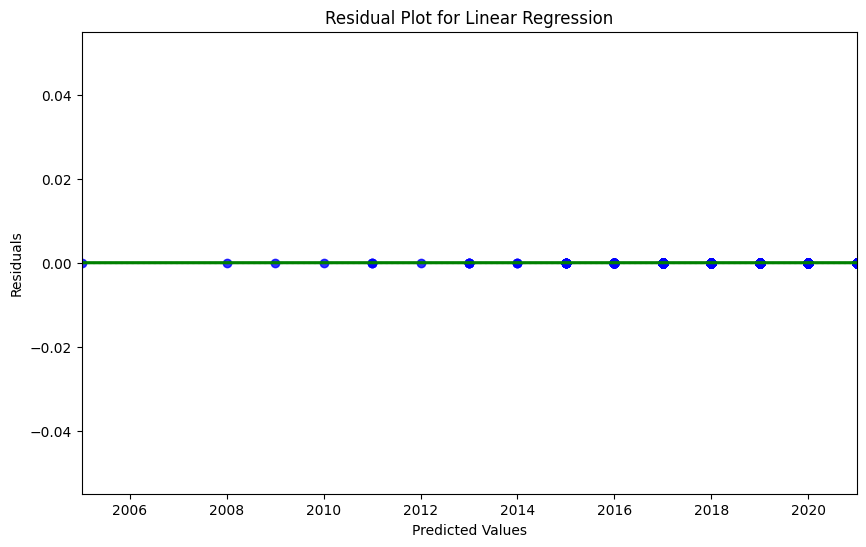

In [25]:
# Visualize residuals for Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

plt.figure(figsize=(10,6))
sns.residplot(x=y_pred_lr, y=(y_test - y_pred_lr), lowess=True, color='blue', line_kws={'color': 'green'})
plt.title('Residual Plot for Linear Regression')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

